In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import numpy as np
from scipy.optimize import fsolve
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import integrate
from scipy.interpolate import interp1d
import pdb
import sys
import matplotlib
plt.rcParams.update({'font.size': 18})

### Goal:
Predict the collapse curve for Ring polymers and confined polymers.

Here is the insight from analysis of size of swollen polymers:

- Ring: the size of a swollen polymer is well represented by $\alpha=\frac{b(N/2)^{3/5}}{bN^{1/2}}$. Hence the swollen size is related to $N/2$, but the ideal size goes with $N$.
- Confinement: Determine the non-confined size. If it is strictly inferior to the confinement, use it. Else, compute the number of monomers needed to have a chain the size of the confinement, and then how many of these chains we can build with our chain. The length is this number of chains times the confinement length.

In the ring case, we need to have a transition between the $N/2$ and the $N$ situations, that is non trivial to model.
The confined situation is a little easier to treat.

#### Ring

For the ring, the simplest treatment would be a sharp cut-off at $\alpha=1$.

Another option would be to identify in the Mean-Field formula the $\alpha^5$ term as the leading term for swollen chain, and to substitute it with $(2^{3/5}\alpha)^5$, while keeping the term $-\alpha^3-y/\alpha^3$ as it is. We can also consider a modification of the 3rd order term.

Note that we might need to take $D\rightarrow 1.25D$.

$\textbf{Alternatively}$, naively take $\alpha_{\text{ring}}=\frac{b(N/2)^\nu}{bN^{1/2}}=2^{1/2-\nu}\alpha_{\text{lin}}$.
Then we need to extract $\nu(\phi, D, d, N)$ numerically from the MF formula.

Compute $\alpha_{\text{lin}}$, and then $\nu=-\frac{\ln{(N^{1/2}\alpha)}}{\ln{(N)}}$


#### Confinement

Now let's treat confined chains.

First determine whether the ideal chain is subjected to confinement.

The formula is: $R_0=b\cdot N^{1/2}$. Determine its confined ideal size $R_0^c$ as described earlier.

Then predict the free $\alpha$, and thus the free end-to-end distance $R$. If it is inferior to confinement, just divide it by the confined ideal size as described above. Then numericaly find $N_c$ such that the length correpsond to the confinement size $D_{conf}$: write $\alpha=\frac{D_{conf}}{b\cdot N_c^{1/2}}$ and solve the mean field equation for $N_c$.

Write $g=N/N_c$, et $R^c=g\cdot D_{conf}$.


1. [Ring](#1.-Ring)
2. [Confined polymer](#2.-Confined-polymer)
3. [Confined Ring](#3.-Confined-Ring)

Addition. [Check bond length](#Addition-Check-Bond-Length)

### 1. Ring

I quite believe it won't work.

We got the simulation from Jung (Ha group) and from Chauhan.

In [3]:
def vv0(phi,D,d):
    shell = (1+d/D)**3 - 1
    E0    = phi*D/d*np.log(1+1.35/shell)/1.25
    #E0    = phi*(D/d)**2*0.22/1.25
    return 1 + (1-np.exp(E0))*shell

def MF_free(a, phi, D, d,b, N):
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    return a**5 - a**3 - y/a**3 - x*vv0(phi,D,d)

def MF(a, phi, D, d,b, N):
    #a = a*2**(1/2) # on ideal chain
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    coef = 1/2**(1/10)
    return (a*coef)**5 - (a*coef)**3 - y/a**3 - x*vv0(phi,D,d)

def alpha_ring(phi, D, d,b, N):
    a = np.empty(phi.shape)
    for i, p in enumerate(phi):
        a[i] = minimize(lambda a: MF(a, p, D, d,b, N)**2, x0=0.11, method='Nelder-Mead').x
    return a

def alpha_ring2(phi, D, d, b,N): # or free
    # Bulk a
    a  = np.empty(phi.shape)
    for i, p in enumerate(phi):
        a[i] = minimize(lambda a: MF_free(a, p, D, d,b, N)**2, x0=1, method='Nelder-Mead').x
    #nu = np.log(N**0.5*a)/np.log(N)
    #return a*2**(0.5-nu)
    return a

<IPython.core.display.Javascript object>


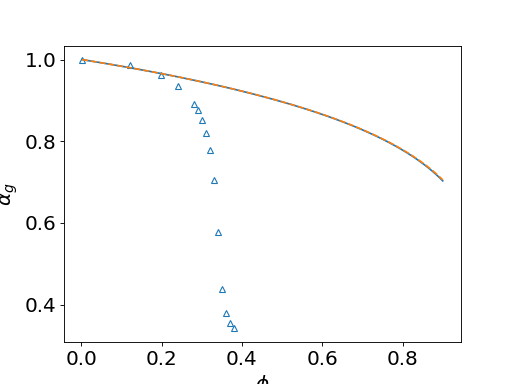

In [4]:
ag  = np.load('data/Jung/JungRing_ag.npy')
phi = np.load('data/Jung/JungRing_phi.npy')

N     = 200 
d     = 1 # nm
D     = 1 # nm
b     = D

phi_vec = np.linspace(min(phi), 0.9, 100)
alpha   = alpha_ring(phi_vec,D,d,b,N)
alpha2  = alpha_ring2(phi_vec,D,d,b,N)

plt.figure()
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\alpha_g$')
#plt.title('Y.Jung simulations')
plt.plot(phi, ag, '^', label='Y.Jung Simulation', fillstyle='none')
plt.plot(phi_vec, alpha/max(alpha), '-', label='Prediction', color=plt.gca().lines[-1].get_color())
plt.plot(phi_vec, alpha2/max(alpha2), '--', label='Prediction 2')
#plt.legend()
#plt.tight_layout()

<IPython.core.display.Javascript object>


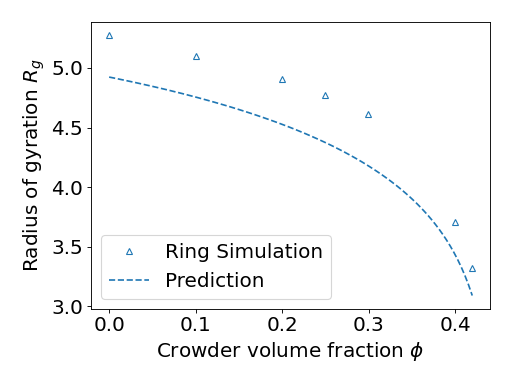

In [5]:
Rg  = np.load('data/data_Chauhan/Chauhan_ag.npy')
phi = np.load('data/data_Chauhan/Chauhan_phi.npy')

N   = 50
sigma = 1 # unsure but unimportant
D     = 1.5*sigma # nm
d     = 0.6*sigma # nm
b     = 1.42*sigma


matplotlib.rcParams.update({'font.size': 18})

phi_vec = np.linspace(min(phi), max(phi), 100)
alpha   = alpha_ring(phi_vec,D,d,b,N)
alpha2  = alpha_ring2(phi_vec,D,d,b,N)

plt.figure()
plt.xlabel(r'Crowder volume fraction $\phi$')
#plt.ylabel(r'Normalize radius of gyration $\alpha_g$')
plt.ylabel('Radius of gyration $R_g$')
#plt.title('G.Chauhan simulations')
#plt.plot(phi, Rg/max(Rg), '^', label='Chauhan Simulation')
#plt.plot(phi_vec, alpha/max(alpha), '-', label='Prediction')#, color=plt.gca().lines[-1].get_color())
#plt.plot(phi_vec, alpha2/max(alpha2), '--', label='Linear Prediction')

plt.plot(phi, Rg, '^', label='Ring Simulation', fillstyle='none')
plt.plot(phi_vec, alpha*D*(N/2)**(1/2)/np.sqrt(6), '--', label='Prediction', color=plt.gca().lines[-1].get_color())#, color=plt.gca().lines[-1].get_color())
#plt.plot(phi_vec, alpha2*D*(N)**(1/2)/np.sqrt(6), '--', label='Linear Prediction')
plt.legend()
plt.tight_layout()

In [6]:
#plt.savefig('')

In [9]:
Rg_sw = D/np.sqrt(6)*(3/5)**(1/5)*(N/2)**(3/5)*(D/b)**(3/5)
print(Rg_sw)
ag_gl = 2**(0)*(5/3)**(1/5)/1.05**(1/3)*N**(-4/15)*(D/b)
print(ag_gl)

alpha2/alpha#*2**(1/2)

3.941773250179015
0.40555606175113157


array([0.9334459 , 0.93343939, 0.93342199, 0.93351559, 0.93349825,
       0.93346994, 0.93350277, 0.9334744 , 0.93349636, 0.93351839,
       0.93354049, 0.933501  , 0.93351211, 0.93352325, 0.93358529,
       0.93353457, 0.93353471, 0.93358596, 0.93357506, 0.93356413,
       0.93355316, 0.93359359, 0.93362297, 0.93360084, 0.93363032,
       0.93364867, 0.93366708, 0.9336223 , 0.93369279, 0.93363657,
       0.93369601, 0.93369194, 0.93368786, 0.93367235, 0.93370945,
       0.9337467 , 0.93377263, 0.93373416, 0.93374865, 0.9337632 ,
       0.93376623, 0.93382276, 0.93381432, 0.93385957, 0.93383949,
       0.93387331, 0.93389555, 0.93390615, 0.9339168 , 0.93391568,
       0.93396925, 0.93401122, 0.93404152, 0.93400486, 0.93407866,
       0.93408537, 0.93413574, 0.93418643, 0.93421318, 0.93424011,
       0.93424281, 0.93430213, 0.93440639, 0.93437271, 0.93445325,
       0.93450957, 0.93455387, 0.93458602, 0.93466404, 0.93471751,
       0.93474613, 0.93489292, 0.93494354, 0.93504136, 0.93511

Conclusion: 

It does not work over the transition. Adding a correction factor inside the formula barely modifies the result. It seems that the ring geometry triggers collapse for lower crowding than expected.

We should dig up to the free energy I guess.

The second method is also a failure.


### 2. Confined polymer

Kim and Yand simulations.

In [7]:
def vv0(phi,D,d,N):
    x     = phi*D/d
    shell = (1+d/D)**3 - 1
    E0    = phi*D/d*np.log(1+1.35/shell)/1.25
    #E0    = phi*(D/d)**2*0.22/1.25
    E0    = E0*np.heaviside(1.25-x, 1) + 0.22*D/d*np.heaviside(x-1.25, 0)
    return 1 + (1-np.exp(E0))*shell

def MF(a, phi, D, d, N, b=np.nan):
    if np.isnan(b):
        b=D
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    return a**5 - a**3 - y/a**3 - x*vv0(phi,D,d,N)

def alpha_conf(phi, D, d, N, Dconf, N_est=N, b=np.nan):
    if np.isnan(b):
        b=D
    R0 = b*N**(1/2) # Ideal length 
    
    if R0>Dconf:
        g       = (Dconf/b)**2
        Nc      = N/g
        R0_conf = Nc*Dconf
    else: 
        R0_conf = R0
        
    a = np.empty(phi.shape)
    for i, p in enumerate(phi):
        a_bulk = minimize(lambda a: MF(a, p, D, d, N, b)**2, x0=2.5, method='Nelder-Mead').x
        R      = a_bulk*R0
        
        if R>Dconf:
            g     = minimize(lambda g: MF(Dconf/D/g**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
            Nc    = N/g
            Rconf = Nc*Dconf
        else:
            Rconf = R
            
        a[i] = Rconf/R0_conf
        
    return a

In [8]:
def phi_MF(a, D, d, N, b=np.nan):
    if np.isnan(b):
        b=D
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    vv0   = (a**5 - a**3 - y/a**3)/x
    shell = (1+d/D)**3-1
    E0    = np.log(1-(vv0-1)/shell)
    coll  = np.log(1+1.35/shell)
    E0phi = coll*D/d/1.25
    return E0/E0phi

In [9]:
# Kim

N     = 80
Dconf = 6 # Usually. There are experiments at different confinement legnth but not considered
d     = np.array([0.2, 0.3, 0.4, 0.6, 0.8])
D     = 1
b     = 0.96*D 

ag  = [np.load('data/data_kim/ag_kim2.npy'), np.load('data/data_kim/ag_kim3.npy'), np.load('data/data_kim/ag_kim4.npy'), np.load('data/data_kim/ag_kim6.npy'), np.load('data/data_kim/ag_kim8.npy')]
phi = [np.load('data/data_kim/ph_kim2.npy'), np.load('data/data_kim/ph_kim3.npy'), np.load('data/data_kim/ph_kim4.npy'), np.load('data/data_kim/ph_kim6.npy'), np.load('data/data_kim/ph_kim8.npy')]

<IPython.core.display.Javascript object>


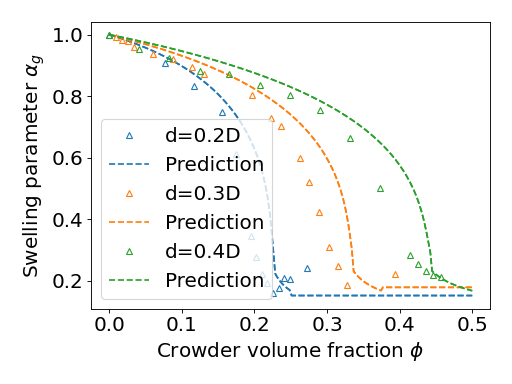

C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:36: RuntimeWarning: invalid value encountered in sqrt
  g     = minimize(lambda g: MF(Dconf/D/g**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:15: RuntimeWarning: invalid value encountered in sqrt
  x = 0.5*np.sqrt(N)*(D/b)**3
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\4104231508.py:10: RuntimeWarning: invalid value encountered in log
  E0    = np.log(1-(vv0-1)/shell)


In [10]:
phi_vec = np.linspace(0, 0.5, 200)
a_vec   = np.linspace(0.1, 2, 50)

plt.figure()
plt.xlabel(r'Crowder volume fraction $\phi$')
plt.ylabel(r'Swelling parameter $\alpha_g$')
#plt.title('Kim Simulations')
for i in range(3):
    a_pred   = alpha_conf(phi_vec, D, d[i], N, Dconf, N, b)
    a_pred_N = alpha_conf(phi_vec, D, d[i], N, Dconf, N*0.2, b)
    phi_bulk = phi_MF(a_vec, D, d[i], N)
    plt.plot(phi[i], ag[i], '^', label='d={:.1f}D'.format(d[i]), fillstyle='none')
    plt.plot(phi_vec, a_pred/max(a_pred), '--', label='Prediction', color=plt.gca().lines[-1].get_color())
    plt.plot(phi_vec, a_pred_N/max(a_pred_N), '--', color=plt.gca().lines[-1].get_color())
    #plt.plot(phi_bulk, a_vec/1.55, ':', label='Bulk pred.', color=plt.gca().lines[-1].get_color()) 
plt.legend()
plt.tight_layout()

In [36]:
#plt.savefig('')

In [37]:
plt.xlim([-0.15, 0.5])

(-0.15, 0.5)

In [38]:
plt.title(None)
plt.tight_layout()

<IPython.core.display.Javascript object>


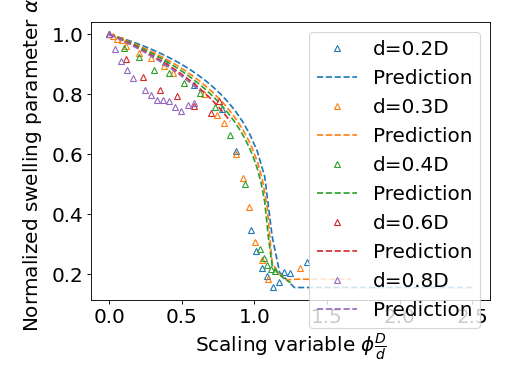

In [11]:
phi_vec = np.linspace(0, 0.5, 50)

plt.figure()
plt.xlabel(r'Scaling variable $\phi\frac{D}{d}$')
plt.ylabel(r'Normalized swelling parameter $\alpha_g$')
for i in range(len(d)):
    a_pred = alpha_conf(phi_vec, D, d[i], N, Dconf)
    plt.plot(phi[i]*D/d[i], ag[i], '^', label='d={:.1f}D'.format(d[i]), fillstyle='none')
    plt.plot(phi_vec*D/d[i], a_pred/max(a_pred), '--', label='Prediction', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.tight_layout()

Looks like a relative success! The transition $\phi$, landing $\phi$ and landing value seem well represented. The scaling found in bulk situation still applies. However the curve does not exactly follows the simulation, and falls abruptly in a 1st order transition. The simulation result is an average, them would not display such a sharp behavior. That is why we can stay confident about the validity of the formula.

Additionnaly, the formula does predict, just after the transition, a slight increase. Is it a numerical artifact or a real feature of the formula. Strangely enough, the simulation also present this behaviour, but it was associated to overcrowding, when the collapse cannot happen anymore due to solvent viscosity. This is a puzzling question.

In [12]:
# Yang-Mannik
# Note: is also a ring ("closed string of beads...")

N     = 150
Dconf = 8 
d     = np.array([20, 32])
D     = 80
b     = D 

ag   = [np.load('data/ag_mannik20.npy'), np.load('data/ag_mannik32.npy')]
phi  = [np.load('data/ph_mannik20.npy'), np.load('data/ph_mannik32.npy')]

<IPython.core.display.Javascript object>


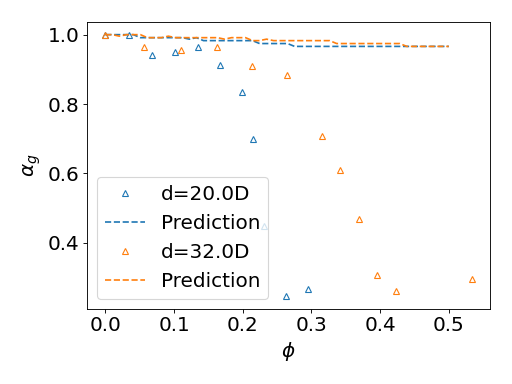

C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:36: RuntimeWarning: invalid value encountered in sqrt
  g     = minimize(lambda g: MF(Dconf/D/g**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:15: RuntimeWarning: invalid value encountered in sqrt
  x = 0.5*np.sqrt(N)*(D/b)**3
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:36: RuntimeWarning: divide by zero encountered in divide
  g     = minimize(lambda g: MF(Dconf/D/g**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\1845351356.py:16: RuntimeWarning: invalid value encountered in subtract
  return a**5 - a**3 - y/a**3 - x*vv0(phi,D,d,N)


In [13]:
phi_vec = np.linspace(0, 0.5, 50)

plt.figure()
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\alpha_g$')
for i in range(len(d)):
    a_pred = alpha_conf(phi_vec, D, d[i], N, Dconf)
    plt.plot(phi[i], ag[i], '^', label='d={:.1f}D'.format(d[i]), fillstyle='none')
    plt.plot(phi_vec, a_pred/max(a_pred), '--', label='Prediction', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.tight_layout()

It does not work but also, it is a ring.

Note that for some reason, the linear bulky equation correctly predicts Yang simulations. But only after normalization.

### 3. Confined Ring

Yang simulations.


In [14]:
def vv0(phi,D,d,N):
    x     = phi*D/d
    shell = (1+d/D)**3 - 1
    E0    = phi*D/d*np.log(1+1.35/shell)/1.25
    #E0    = phi*(D/d)**2*0.22/1.25
    #E0    = E0*np.heaviside(1.25-x, 1) + 0.22*D/d*np.heaviside(x-1.25, 0)
    E0    = E0*(x<1.25) + 0.22*D/d*(x>=1.25)
    return 1 + (1-np.exp(E0))*shell

def MF(a, phi, D, d, N, b=np.nan):
    if np.isnan(b):
        b=D
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    return (a/2**(1/10))**5 - (a/2**(1/10))**3 - y/a**3 - x*vv0(phi,D,d,N)

def alpha_conf(phi, D, d, N, Dconf, N_est=N, b=np.nan):
    if np.isnan(b):
        b=D
    R0 = b*(N/2)**(1/2) # Ideal length 
    
    if R0>Dconf:
        g       = 2*(Dconf/b)**2
        Nc      = N/g
        R0_conf = Nc*Dconf
    else: 
        R0_conf = R0
        
    a      = np.empty(phi.shape)
    a_free = np.empty(phi.shape)
    for i, p in enumerate(phi):
        a_bulk    = minimize(lambda a: MF(a, p, D, d, N, b)**2, x0=2.5, method='Nelder-Mead').x
        a_free[i] = a_bulk
        R         = a_bulk*R0
        
        if R>Dconf:
            g     = minimize(lambda g: MF(Dconf/b/(g/2)**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
            Nc    = N/g
            Rconf = Nc*Dconf
        else:
            Rconf = R
            
        a[i] = Rconf/R0_conf
        alpha_conf.alpha_free = a_free
    return a

In [15]:
def phi_MF(a, D, d, N, b=np.nan):
    if np.isnan(b):
        b=D
    #y = 1/5*(D/b)**6
    #x = 3/5*np.sqrt(N)*(D/b)**3
    y = 1/6*(D/b)**6
    x = 0.5*np.sqrt(N)*(D/b)**3
    vv0   = ((a/2**0.1)**5 - (a/2**0.1)**3 - y/a**3)/x
    shell = (1+d/D)**3-1
    E0    = np.log(1-(vv0-1)/shell)
    coll  = np.log(1+1.35/shell)
    E0phi = coll*D/d/1.25
    return E0/E0phi

In [16]:
# Yang-Mannik
# Note: is also a ring ("closed string of beads...")

N     = 150
d     = np.array([20, 32])
D     = 80
Dconf = 8*D
b     = 0.96*D 

ag   = [np.load('data/data_Yang/ag_mannik20.npy'), np.load('data/data_Yang/ag_mannik32.npy')]
phi  = [np.load('data/data_Yang/ph_mannik20.npy'), np.load('data/data_Yang/ph_mannik32.npy')]

<IPython.core.display.Javascript object>


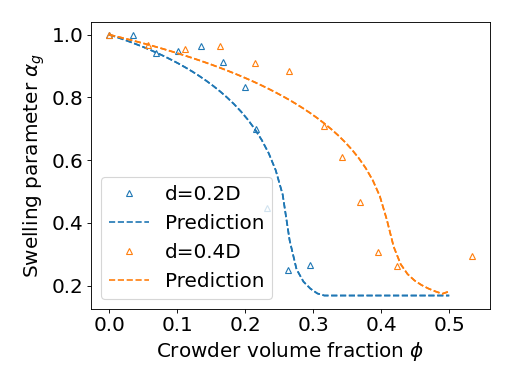

C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\412369143.py:39: RuntimeWarning: invalid value encountered in sqrt
  g     = minimize(lambda g: MF(Dconf/b/(g/2)**(1/2), p, D, d, g, b)**2, x0=N_est, method='Nelder-Mead').x
C:\Users\Quentin\AppData\Local\Temp\ipykernel_3268\412369143.py:16: RuntimeWarning: invalid value encountered in sqrt
  x = 0.5*np.sqrt(N)*(D/b)**3


In [17]:
phi_vec = np.linspace(0, 0.5, 50)

matplotlib.rcParams.update({'font.size': 18})

plt.figure()
plt.xlabel(r'Crowder volume fraction $\phi$')
plt.ylabel(r'Swelling parameter $\alpha_g$')
for i in range(len(d)):
    a_pred = alpha_conf(phi_vec, D, d[i], N, Dconf, N, b)
    a_pred2 = alpha_conf(phi_vec, D, d[i], N, Dconf, N*0.2, b)
    plt.plot(phi[i], ag[i], '^', label='d={:.1f}D'.format(d[i]/D), fillstyle='none')
    plt.plot(phi_vec, a_pred/max(a_pred), '--', label='Prediction', color=plt.gca().lines[-1].get_color())
    plt.plot(phi_vec, a_pred2/max(a_pred2), '--', color=plt.gca().lines[-1].get_color())
    a_free = alpha_conf.alpha_free
    #plt.plot(phi_vec, a_free/max(a_free), '-', label='Bulk Prediction', color=plt.gca().lines[-1].get_color())
plt.legend()
plt.tight_layout()

In [46]:
#plt.savefig('')

In [221]:
b*(N/2)**(1/2)/Dconf

1.0392304845413265

### Addition-Check-Bond-Length

<IPython.core.display.Javascript object>


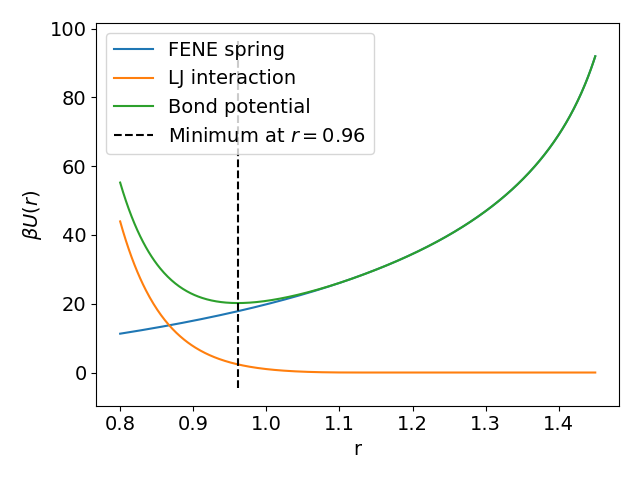

In [162]:
r = np.linspace(0.8, 1.45, 500)

# Jung -> In fact mean field simulation
sigma = 1
k0    = 30/sigma**2
r0    = 1.5*sigma**2
UFENE = -1/2*k0*r0**2*np.log(1-(r/r0)**2)
ULJ   = 4*(1/r)**12*(r<1) #Truncated
'''
# Chauhan
sigma = 1
r0    = 2*sigma
k0    = 15/sigma**2
D     = 1.5*sigma
UFENE = -1/2*k0*r0**2*np.log(1-(r/r0)**2)
ULJ   = (4*((D/r)**12 - (D/r)**6) +1 )*(r<=2**(1/6)*D) # WCA potential
imin  = np.argmin(UFENE+ULJ)
'''

# Kim
sigma = 1
r0    = 1.5*sigma
k0    = 30/sigma**2
D     = sigma
UFENE = -1/2*k0*r0**2*np.log(1-(r/r0)**2)
ULJ   = (4*((D/r)**12 - (D/r)**6)+ 1 )*(r<=2**(1/6)*D) # WCA potential
imin  = np.argmin(UFENE+ULJ)

'''
# Yang-Mannik
sigma = 1
r0    = 1.5*sigma
k0    = 30/sigma**2
D     = sigma
UFENE = -1/2*k0*r0**2*np.log(1-(r/r0)**2)
ULJ   = (4*((D/r)**12 - (D/r)**6)+ 1 )*(r<=2**(1/6)*D) # WCA potential
imin  = np.argmin(UFENE+ULJ)
'''

plt.figure()
plt.xlabel('r')
plt.ylabel('$\\beta U(r)$')
plt.plot(r, UFENE, label='FENE spring')
plt.plot(r, ULJ, label='LJ interaction')
plt.plot(r, UFENE+ULJ, label='Bond potential')
plt.plot([r[imin], r[imin]], plt.ylim(), 'k--', label='Minimum at $r={:.2f}$'.format(r[imin]))
#plt.ylim([-20, 200])
plt.legend()
plt.tight_layout()